In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm

import matplotlib.patches as mpatches

from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

sstyle = 'seaborn-v0_8-poster'
plt.style.use(sstyle)
plt.rc('font',family = 'serif')

pd.set_option('display.max_columns', None)

coeffs = ['IP', 'BT', 'NEL', 'PLTH', 'RGEO', 'KAREA', 'EPS', 'MEFF']
path = "../data/"
fig_path = "../../../LATEX/Latex Images/"

In [3]:
# REMARK: There are no spherical TOKAMAKs in these analyses.  

DB2P8 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False)

# There is two shots from DB2P8 missing in DB5
missing_shots = DB2P8[~DB2P8.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# How was this chosen? Is this a form of removing outliers or noise to the new regression?
# Why not simply use the whole DB5?
new_ids = pd.read_csv(path+"new_point_ids.csv")
                  
R = pd.read_csv(path+"R.csv") #DB5[DB5.id.isin(new_ids.id.values)] #reintroduce dataset

DB2 = DB2P8[["TAUTH"] + coeffs].apply(np.abs).apply(np.log)
DB2["id"] = DB2P8["id"]

reg_data = pd.read_csv(path+"data.csv")

In [4]:
def get_regression_np(_R):
    data = pd.concat([DB2, _R],
                     axis=0, 
                     ignore_index=True
                    )
    Y_ = data[["TAUTH"]].to_numpy()
    # Adding a column for the intercept
    _df = data[coeffs]; _df.insert(
        loc = 0, 
        column = "intercept", 
        value = np.ones(len(_df))
    )
    X_ = _df.to_numpy()
    n_, p_ = X_.shape
    model = sm.OLS(Y_,X_)
    regression = model.fit()
    return data, regression, (n_,p_)

# Getting regression of DB2P8 only. 
regression_DB2 = get_regression_np(R[R.id.isin([0])])[1]
#regression_DB2.summary()

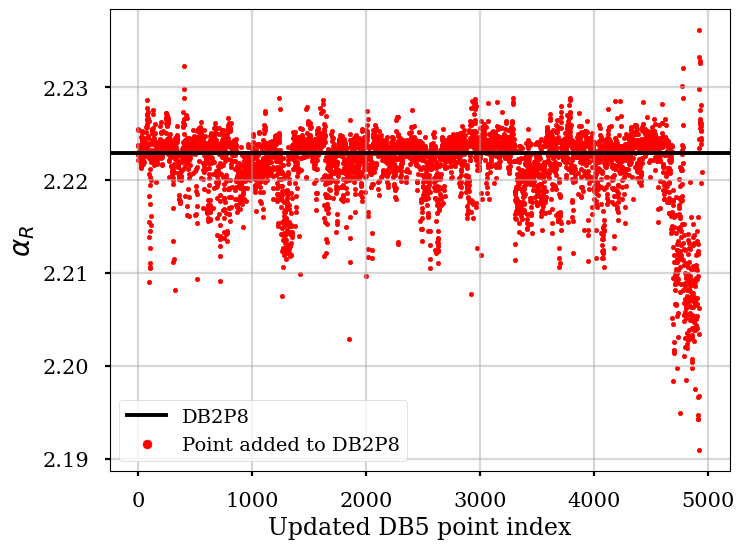

In [5]:
plt.figure(figsize=(8,6))
plt.axhline(regression_DB2.params[5], c="k", label="DB2P8")
plt.scatter(reg_data.index, reg_data.αR, s=10, c = "red", label="Point added to DB2P8")
plt.xlabel("Updated DB5 point index",fontsize=17)
plt.ylabel("$\\alpha_R$", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=14, markerscale=2)

plt.rc('axes', axisbelow=True)
plt.grid(alpha=0.5);

#plt.savefig(fig_path+"individual_pts.pdf", format="pdf", dpi=800, bbox_inches='tight');

In [6]:
# Leave the ones above baseline out -- because we are interested in the reduction of value
pts_minimize = reg_data[reg_data.αR < regression_DB2.params[5] ]
pts_minimize = pts_minimize.sort_values("αR", ascending=True)

# Ordering dataset ids from smallest to greatest alpha-R 
dict_ordered_vals = dict(zip( 
    pts_minimize.id_added.values, 
    list(range(len(pts_minimize)))  
) )

DB5_decreas_pts = R[R.id.isin(pts_minimize.id_added)]
DB5_decreas_pts.insert(0, "ordered", DB5_decreas_pts.id.map(dict_ordered_vals))

DB5_decreas_pts = DB5_decreas_pts.sort_values("ordered")
DB5_decreas_pts = DB5_decreas_pts.set_index("ordered")

In [7]:
pts_minimize.TOK_added.unique()

array(['START', 'NSTX', 'MAST', 'JET', 'D3D', 'AUG', 'AUGW', 'JETILW',
       'JT60U', 'TFTR', 'COMPASS', 'CMOD'], dtype=object)

In [8]:
pts_minimize

,TOK_added,DATE_added,SHOT_added,TIME_added,α0,αI,αB,αn,αP,αR,αk,αe,αM,id_added,ind
4916,START,19980303,36080,0.043,0.051663,0.792360,0.303846,0.426743,-0.667195,2.19092,0.379690,0.570527,0.182227,AEWB71,4917
4912,START,19971111,34882,0.041,0.051243,0.790704,0.305245,0.427913,-0.665620,2.19423,0.379033,0.569247,0.181412,UAAXGA,4913
4911,START,19971111,34877,0.041,0.051248,0.790514,0.305470,0.427923,-0.665611,2.19431,0.379264,0.569610,0.181405,53LSPJ,4912
4914,START,19980303,36078,0.042,0.051217,0.790618,0.305768,0.427929,-0.665882,2.19474,0.379609,0.569316,0.181426,FLO8WI,4915
4749,NSTX,20040427,112453,0.360,0.051531,0.792834,0.299394,0.429275,-0.665955,2.19494,0.373501,0.570557,0.182654,TKCDLW,4750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2811,JETILW,20160902,91752,46.300,0.049507,0.780981,0.320311,0.435320,-0.668702,2.22296,0.390257,0.575847,0.182751,K3O76W,2812
2765,JETILW,20160816,91479,50.000,0.049367,0.780211,0.323407,0.434725,-0.669495,2.22296,0.392433,0.576414,0.186584,ZD6MZS,2766
1174,AUGW,20120619,28196,3.250,0.049593,0.781520,0.319668,0.435144,-0.668432,2.22296,0.389753,0.575329,0.179849,ZPPYT0,1175
1515,JET,19970930,42762,53.370,0.049841,0.780763,0.319443,0.435022,-0.669238,2.22296,0.392193,0.578453,0.178395,Q48F9L,1516


In [11]:
#pts_minimize["id_added"].to_csv(path+"decreased_DB5.csv", index=False)

In [ ]:
reg_coeff_per_pts = np.zeros(len(pts_minimize))
for i in range(1, len(pts_minimize) + 1):
    # Adding one point at a time to DB2P8 from DB5 od decreasing subset in an ordered manner.
    R_ = (DB5_decreas_pts.iloc[:i][["TAUTH"] + coeffs])
    # Storing regression coefficient for alpha_R only
    reg_coeff_per_pts[i-1] = get_regression_np(R_)[1].params[5]
    
DB5_decreas_pts["αR_per_pts_in_DB2"] = reg_coeff_per_pts

In [ ]:
#%matplotlib notebook

plt.figure(figsize=(8,6))
plt.scatter(DB5_decreas_pts.index + 1, DB5_decreas_pts["αR_per_pts_in_DB2"], s=12, c = "red")
plt.xlabel("Amount of points added to DB2", fontsize=17)
plt.ylabel("$\\alpha_R$", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.title("Change of $\\alpha_R$ When Adding One Shot At a Time")
plt.rc('axes', axisbelow=True)
plt.grid(alpha=0.5)


ax = plt.gca()
ax.set_ylim([1.12, 1.2])
ax.set_xlim([520, 600]);

#plt.savefig(fig_path+"accumulated_pts_zoom.pdf", format="pdf", dpi=800, bbox_inches='tight');

In [ ]:
big_dataset = pd.read_csv(path+"decreased_dataset_random_sampling_500.csv")


small_dataset = pd.read_csv(path+"decreased_dataset_random_sampling_500_decreasing_points.csv")

big_dataset   = big_dataset.set_index("seed")
small_dataset = small_dataset.set_index("seed")

In [ ]:
plt.figure(figsize=(8,6))

for s in small_dataset.index:
    plt.scatter( range(1, len(small_dataset.columns)+1) , small_dataset.loc[s].values, s=1, c="red")
    plt.scatter( range(1, len(big_dataset.columns)+1) , big_dataset.loc[s].values, s=1, c="slategrey")


plt.scatter([0],[regression_DB2.params[5]], s=1, c="red", label = "decreasing points")
plt.scatter([0],[regression_DB2.params[5]], s=1, c="slategrey", label = "decreasing set")



#plt.title("Decreasing Points")
plt.xlabel("Amount of random samples", fontsize=17)
plt.ylabel("$\\alpha_R$", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.rc('axes', axisbelow=True)
plt.grid(alpha=0.5)

plt.legend(fontsize=16, markerscale=7)

#plt.savefig(fig_path+"comparison_decreasing_set_vs_pts.jpg", format="jpg", dpi=900, bbox_inches='tight');

In [ ]:
plt.figure(figsize=(8,6))

for s in small_dataset.index:
    plt.scatter( range(1, len(small_dataset.columns)+1) , small_dataset.loc[s].values, s=7, c="red", marker=".")

plt.xlabel("Amount of random samples", fontsize=17)
plt.ylabel("$\\alpha_R$", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.rc('axes', axisbelow=True)
plt.grid(alpha=0.5)

plt.grid(alpha=0.5)
ax = plt.gca()
ax.set_ylim([0.6, 1.01])
ax.set_xlim([600, len(small_dataset.columns)*1.005]);
#plt.savefig(fig_path+"comparison_decreasing_set_vs_pts_zoom.jpg", format="jpg", dpi=900, bbox_inches='tight');

In [ ]:
min(small_dataset["subset_1388"])

In [ ]:
# Seed
small_dataset.index[np.argmin(small_dataset["subset_1388"])]

In [ ]:
(1 - 1388/(len(R)+len(DB2)))*100

In [ ]:
77.8 + 22.2

In [ ]:
#|pd.set_option('display.max_rows', None)

df = small_dataset.describe().T
df[df["min"] < 1].head()

In [ ]:
min(small_dataset["subset_618"])

In [ ]:
small_dataset.index[np.argmin(small_dataset["subset_618"])]